# Exploratory Data Analysis

## Hardcoded Variables

In [32]:
weathercan_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/weathercan_data.csv"

## Import Libraries

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Utility Functions

## Data Engineering

In [ ]:
# todo:
# clean morrisey data
# merge to weather df
# calculate monthly mean precip for each weather station if not already given

# get hydrometric data
# show summary of hydrometric 

In [34]:
weathercan_df = pd.read_csv(weathercan_path)

C:\Users\14037\AppData\Local\Temp\ipykernel_28828\3573525454.py:1: DtypeWarning: Columns (7,9,14,16,18,20,22,24,26,28,30,32,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  weathercan_df = pd.read_csv(weathercan_path)


In [35]:
columns_to_drop = ['station_operator', 'climate_id', 'WMO_id', 'TC_id']

# Drop specified columns and columns containing the word 'flag'
weathercan_df.drop(columns=columns_to_drop + [col for col in weathercan_df.columns if 'flag' in col.lower()], inplace=True)
weathercan_df

,station_name,station_id,prov,lat,lon,elev,date,year,month,day,...,dir_max_gust,heat_deg_days,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow
0,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-01,1998,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-02,1998,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-03,1998,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-04,1998,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-05,1998,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252959,NATAL HARMER RIDGE,1203,BC,49.77,-114.83,1889.8,2024-01-05,2024,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252960,NATAL HARMER RIDGE,1203,BC,49.77,-114.83,1889.8,2024-01-06,2024,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252961,NATAL HARMER RIDGE,1203,BC,49.77,-114.83,1889.8,2024-01-07,2024,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252962,NATAL HARMER RIDGE,1203,BC,49.77,-114.83,1889.8,2024-01-08,2024,1,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
weathercan_df.dtypes

station_name      object
station_id         int64
prov              object
lat              float64
lon              float64
elev             float64
date              object
year               int64
month              int64
day                int64
qual              object
cool_deg_days    float64
dir_max_gust     float64
heat_deg_days    float64
max_temp         float64
mean_temp        float64
min_temp         float64
snow_grnd        float64
spd_max_gust     float64
total_precip     float64
total_rain       float64
total_snow       float64
dtype: object

In [37]:
weathercan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252964 entries, 0 to 252963
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   station_name   252964 non-null  object 
 1   station_id     252964 non-null  int64  
 2   prov           252964 non-null  object 
 3   lat            252964 non-null  float64
 4   lon            252964 non-null  float64
 5   elev           252964 non-null  float64
 6   date           252964 non-null  object 
 7   year           252964 non-null  int64  
 8   month          252964 non-null  int64  
 9   day            252964 non-null  int64  
 10  qual           4376 non-null    object 
 11  cool_deg_days  87904 non-null   float64
 12  dir_max_gust   9675 non-null    float64
 13  heat_deg_days  87904 non-null   float64
 14  max_temp       88589 non-null   float64
 15  mean_temp      87904 non-null   float64
 16  min_temp       88441 non-null   float64
 17  snow_grnd      30206 non-null

In [38]:
weathercan_df.describe()

,station_id,lat,lon,elev,year,month,day,cool_deg_days,dir_max_gust,heat_deg_days,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow
count,252964.000000,252964.000000,252964.000000,252964.000000,252964.000000,252964.000000,252964.000000,87904.000000,9675.000000,87904.000000,88589.000000,87904.000000,88441.000000,30206.000000,9689.000000,95347.000000,84534.000000,84217.000000
mean,3464.557309,49.655352,-114.653038,1434.898146,1993.912565,6.521932,15.723965,0.059819,22.077933,13.970152,9.907873,4.089667,-1.713378,3.508839,45.331304,1.703974,1.056014,0.682720
std,3360.973505,0.074238,0.177598,298.557997,22.685303,3.450484,8.801228,0.388037,7.764023,9.442429,10.885867,9.538417,9.011552,9.868882,11.804038,4.534458,3.612641,2.918515
min,1170.000000,49.520000,-114.920000,1127.800000,1912.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-35.600000,-37.000000,-43.000000,0.000000,31.000000,0.000000,0.000000,0.000000
25%,1204.000000,49.620000,-114.880000,1143.000000,1981.000000,4.000000,8.000000,0.000000,15.000000,6.500000,2.200000,-1.700000,-6.000000,0.000000,37.000000,0.000000,0.000000,0.000000
50%,2381.000000,49.630000,-114.580000,1341.100000,1999.000000,7.000000,16.000000,0.000000,20.000000,13.100000,10.000000,4.900000,-0.300000,0.000000,43.000000,0.000000,0.000000,0.000000
75%,2396.000000,49.750000,-114.500000,1572.200000,2011.000000,10.000000,23.000000,0.000000,29.000000,19.700000,18.400000,11.500000,4.600000,0.000000,52.000000,1.000000,0.000000,0.000000
max,10890.000000,49.770000,-114.430000,2072.600000,2024.000000,12.000000,31.000000,8.400000,36.000000,55.000000,37.600000,26.400000,21.100000,133.000000,122.000000,103.000000,88.000000,102.400000


In [63]:

weathercan_df['monthly_mean_precip'] = (
    weathercan_df.groupby(['station_name', 'year', 'month'])['total_precip']
    .transform('mean')
)
weathercan_df

,station_name,station_id,prov,lat,lon,elev,date,year,month,day,...,heat_deg_days,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow,monthly_mean_precip
0,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-01,1998,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-02,1998,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-03,1998,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-04,1998,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-05,1998,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252959,NATAL HARMER RIDGE,1203,BC,49.77,-114.83,1889.8,2024-01-05,2024,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252960,NATAL HARMER RIDGE,1203,BC,49.77,-114.83,1889.8,2024-01-06,2024,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252961,NATAL HARMER RIDGE,1203,BC,49.77,-114.83,1889.8,2024-01-07,2024,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252962,NATAL HARMER RIDGE,1203,BC,49.77,-114.83,1889.8,2024-01-08,2024,1,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:

# Replace 'your_dataframe' with the actual name of your DataFrame

# Group by 'station_name'
grouped_df = weathercan_df.groupby('station_name')

# Create a dictionary to store DataFrames
station_dfs = {}

# Iterate through groups and create DataFrames
for station_name, station_group in grouped_df:
    # Name each DataFrame based on station_name
    df_name = station_name.replace(' ', '_') + '_df'
    # Add the DataFrame to the dictionary
    station_dfs[df_name] = station_group.copy()

# Get the list of all new station DataFrame names
new_station_df_names = list(station_dfs.keys())

# Print the list of new station DataFrame names
print(new_station_df_names)

['BLAIRMORE_HQTS_RS_df', 'COLEMAN_df', 'COLEMAN_RS_df', 'CORBIN_df', 'CROWSNEST_df', 'CROWSNEST_CREEK_df', 'IRONSTONE_LO_df', 'NATAL_df', 'NATAL_HARMER_RIDGE_df', 'NATAL_KAISER_RESOURCES_df', 'PELLETIER_CREEK_df', 'SPARWOOD_df', 'SPARWOOD_CS_df', 'WILLOUGHBY_RIDGE_df']


In [41]:
def describe_dataframes_to_dataframe(dataframes_dict):
    """
    Takes a dictionary of DataFrames and creates a new DataFrame with the summary statistics
    from the .describe() method for each DataFrame.

    Parameters:
    - dataframes_dict: Dictionary where keys are DataFrame names and values are DataFrames.

    Returns:
    - summary_df: DataFrame containing summary statistics for each input DataFrame.
    """
    summary_data = {}
    
    for df_name, df in dataframes_dict.items():
        summary_data[df_name] = df.describe()
    
    summary_df = pd.concat(summary_data, axis=1).T
    return summary_df

In [42]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [43]:
summary_df = describe_dataframes_to_dataframe(station_dfs)
summary_df

count  \
BLAIRMORE_HQTS_RS_df      station_id     19367.0   
                          lat            19367.0   
                          lon            19367.0   
                          elev           19367.0   
                          date             19367   
                          year           19367.0   
                          month          19367.0   
                          day            19367.0   
                          cool_deg_days   7066.0   
                          dir_max_gust       0.0   
                          heat_deg_days   7066.0   
                          max_temp        7096.0   
                          mean_temp       7066.0   
                          min_temp        7141.0   
                          snow_grnd       3333.0   
                          spd_max_gust       0.0   
                          total_precip    7204.0   
                          total_rain      7203.0   
                          total_snow      7205.0   
COLEMAN_df                station_id     40643.0   
                          lat            40643.0   
                          lon            40643.0   
                          elev           40643.0   
                          date             40643   
                          year           40643.0   
                          month          40643.0   
                          day            40643.0   
                          cool_deg_days  11901.0   
                          dir_max_gust       0.0   
                          heat_deg_days  11901.0   
                          max_temp       11939.0   
                          mean_temp      11901.0   
                          min_temp       11910.0   
                          snow_grnd       3253.0   
                          spd_max_gust       0.0   
                          total_precip   29964.0   
                          total_rain     29965.0   
                          total_snow     29965.0   
COLEMAN_RS_df             station_id     24115.0   
                          lat            24115.0   
                          lon            24115.0   
                          elev           24115.0   
                          date             24115   
                          year           24115.0   
                          month          24115.0   
                          day            24115.0   
                          cool_deg_days   2236.0   
                          dir_max_gust       0.0   
                          heat_deg_days   2236.0   
                          max_temp        2355.0   
                          mean_temp       2236.0   
                          min_temp        2259.0   
                          snow_grnd          0.0   
                          spd_max_gust       0.0   
                          total_precip    2963.0   
                          total_rain      2965.0   
                          total_snow      2932.0   
CORBIN_df                 station_id     17175.0   
                          lat            17175.0   
                          lon            17175.0   
                          elev           17175.0   
                          date             17175   
                          year           17175.0   
                          month          17175.0   
                          day            17175.0   
                          cool_deg_days   5759.0   
                          dir_max_gust       0.0   
                          heat_deg_days   5759.0   
                          max_temp        5767.0   
                          mean_temp       5759.0   
                          min_temp        5775.0   
                          snow_grnd       2492.0   
                          spd_max_gust       0.0   
                          total_precip    5426.0   
                          total_rain      5460.0   
                          total_snow      5434.0   
CROWSNEST_df              station_id   

In [44]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

In [49]:
CROWSNEST_CREEK_df = station_dfs['CROWSNEST_CREEK_df']

# Group by 'year' and 'month' and calculate the mean precipitation
CROWSNEST_CREEK_df['monthly_mean_precip'] = (
    CROWSNEST_CREEK_df.groupby(['year', 'month'])['total_precip']
    .transform('mean'))

CROWSNEST_CREEK_df

,station_name,station_id,prov,lat,lon,elev,date,year,month,day,...,heat_deg_days,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow,monthly_mean_precip
0,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-01,1998,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-02,1998,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-03,1998,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-04,1998,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-05,1998,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9500,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-05,2024,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9501,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-06,2024,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9502,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-07,2024,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9503,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-08,2024,1,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
distinct_values_crowsnest_year = CROWSNEST_CREEK_df['year'].unique()
distinct_values_crowsnest_year

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024], dtype=int64)

In [52]:
distinct_values_crowsnest_year_counts = CROWSNEST_CREEK_df['year'].value_counts()
distinct_values_crowsnest_year_counts

year
2000    366
2004    366
2020    366
2008    366
2016    366
2012    366
1998    365
2014    365
2023    365
2022    365
2021    365
2019    365
2018    365
2017    365
2015    365
2011    365
2013    365
1999    365
2010    365
2009    365
2007    365
2006    365
2005    365
2003    365
2002    365
2001    365
2024      9
Name: count, dtype: int64

In [53]:
distinct_values_crowsnest = CROWSNEST_CREEK_df['monthly_mean_precip'].unique()
distinct_values_crowsnest

array([       nan, 0.67419355, 2.12333333, 2.1516129 , 1.13225806,
       1.04642857, 0.91290323, 1.24333333, 2.08064516, 3.10666667,
       1.21612903, 2.17741935, 0.92666667, 2.88709677, 2.65666667,
       0.55806452, 1.83548387, 0.91724138, 1.25483871, 0.88666667,
       2.26451613, 3.52666667, 0.77096774, 0.8516129 , 0.96774194,
       0.40645161, 0.93214286, 1.26129032, 2.28965517, 0.59677419,
       3.62      , 0.32258065, 0.15806452, 0.4       , 1.44193548,
       1.06      , 1.03225806, 2.4       , 2.05714286, 1.38709677,
       1.33      , 3.2483871 , 3.80666667, 0.56129032, 1.17741935,
       2.45333333, 0.74333333, 1.39677419, 1.32903226, 0.30357143,
       2.59032258, 2.39666667, 1.78064516, 1.82      , 0.12258065,
       0.11612903, 0.78      , 2.3483871 , 2.05333333, 0.11724138,
       1.0483871 , 0.78333333, 1.85483871, 3.24666667, 1.71935484,
       3.19354839, 2.18333333, 1.51612903, 1.14      , 1.2       ,
       2.01290323, 1.25      , 1.18709677, 0.99666667, 1.71612

In [56]:
monthly_mean_precip_counts = (
    CROWSNEST_CREEK_df.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)
monthly_mean_precip_counts

,year,monthly_mean_precip,counts
0,1998,0.674194,31
1,1998,2.123333,30
2,1998,2.151613,31
3,1999,0.558065,31
4,1999,0.912903,31
...,...,...,...
78,2005,2.830769,30
79,2005,3.106452,31
80,2005,5.123333,30
81,2005,7.830000,30


In [65]:
# Filter the DataFrame for the station 'CROWSNEST_CREEK'
CROWSNEST_CREEK_df_from_wc = weathercan_df[weathercan_df['station_name'] == 'CROWSNEST CREEK']

# Group by 'year' and 'monthly_mean_precip' and get value counts
monthly_mean_precip_counts_wc = (
    CROWSNEST_CREEK_df_from_wc.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)

# Print or use the resulting DataFrame as needed
monthly_mean_precip_counts_wc

,year,monthly_mean_precip,counts
0,1998,0.674194,31
1,1998,2.123333,30
2,1998,2.151613,31
3,1999,0.558065,31
4,1999,0.912903,31
...,...,...,...
78,2005,2.830769,30
79,2005,3.106452,31
80,2005,5.123333,30
81,2005,7.830000,30


### Creating monthly mean precip data for all weather stations

## Plots & Analysis

In [ ]:
# todo:

# plot mean monthly precip for each weather station
# plot elevation for each weather station with elevation of upper and lower reservoir as lines, vs mean monthly precip
# plot mean monethly precip over the months of all weather stations

# plot SWE
# hydrometric?

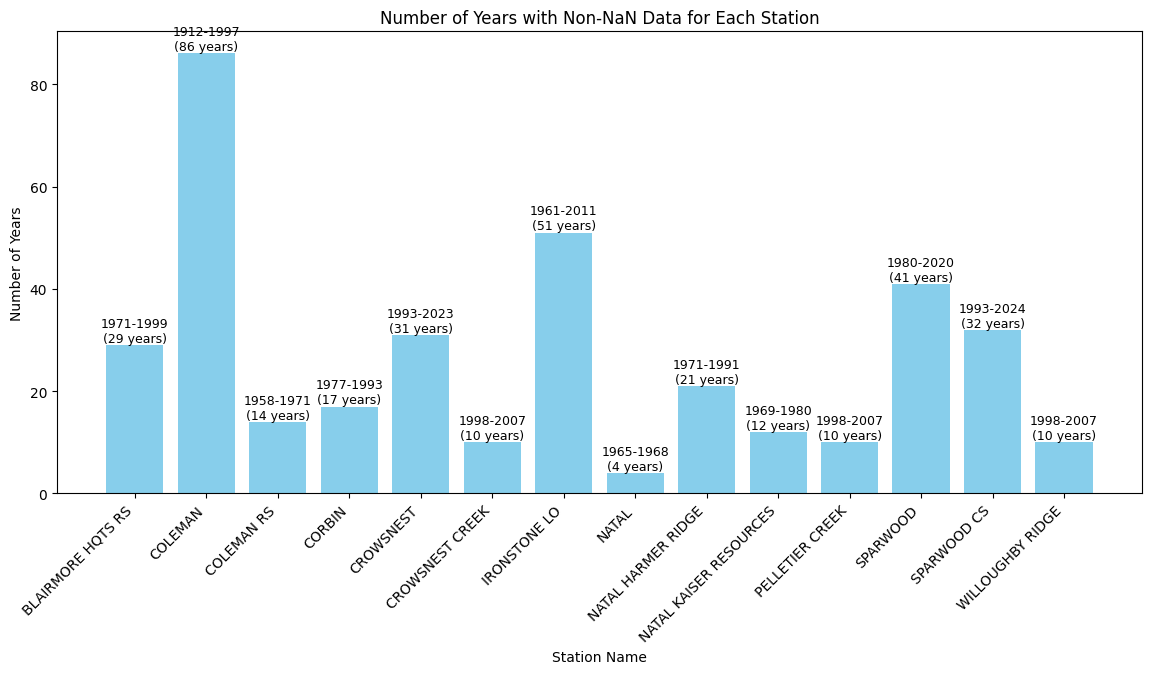

In [81]:
# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the histogram with the correct year range and station names
plt.figure(figsize=(14, 6))

# Plotting the bar chart
bar_plot = plt.bar(station_years_range.index, station_years_range['count'], color='skyblue')

# Adding text on top of each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    end_year = min(max_year, weathercan_df['year'].max())  # Set the maximum year to the overall max year
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{min_year}-{end_year}\n({count} years)",
             ha='center', va='bottom', fontsize=9, color='black')

plt.title('Number of Years with Non-NaN Data for Each Station')
plt.xlabel('Station Name')
plt.ylabel('Number of Years')
plt.xticks(rotation=45, ha='right')
plt.show()

In [83]:
# Filter data for the 'SPARWOOD' station and exclude rows with NaN in 'total_precip'
sparwood_df_from_wc = weathercan_df[(weathercan_df['station_name'] == 'SPARWOOD') & ~weathercan_df['total_precip'].isna()]

# Get distinct years for the 'SPARWOOD' station
distinct_values_sparwood_year = sparwood_df_from_wc['year'].unique()
distinct_values_sparwood_year

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

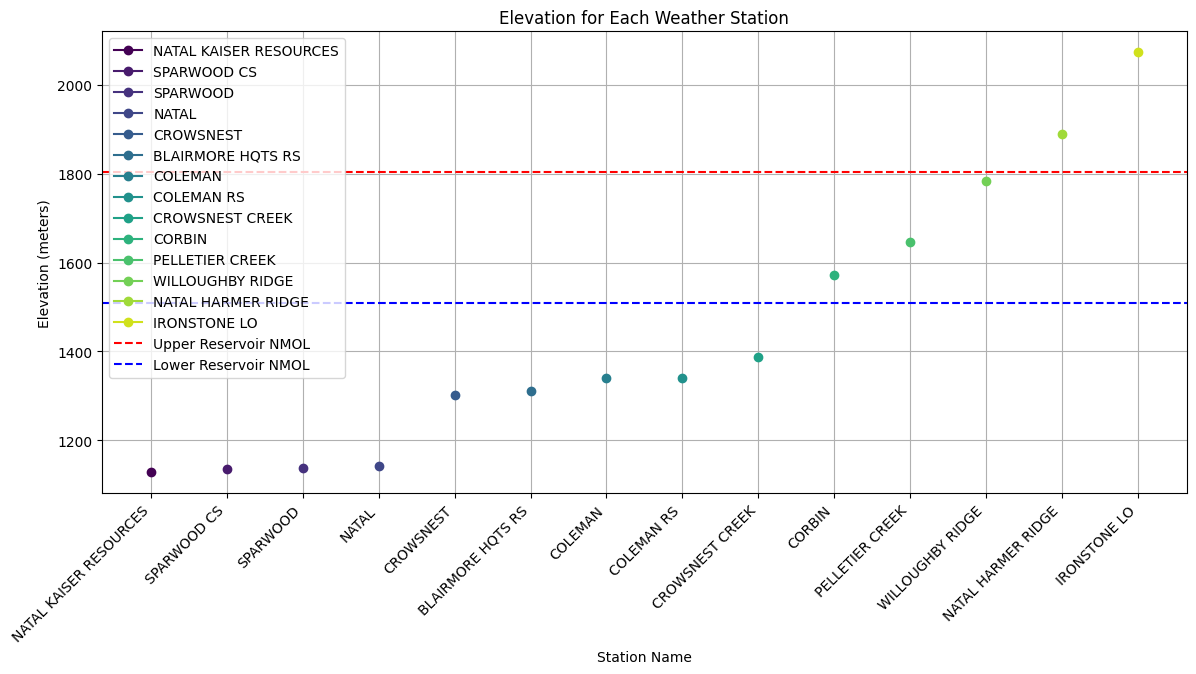

In [90]:
# Group by 'station_name' and get the mean elevation for each station
station_elevation = weathercan_df.groupby('station_name')['elev'].mean().reset_index()

# Sorting the data by elevation for better visualization
station_elevation = station_elevation.sort_values(by='elev')

# Elevation values for Upper and Lower Reservoir NMOL
upper_reservoir_elevation = 1803.3
lower_reservoir_elevation = 1509

# Plotting the line chart for station elevations with labels and different colors
plt.figure(figsize=(14, 6))
for i, (station, elevation) in enumerate(zip(station_elevation['station_name'], station_elevation['elev'])):
    plt.plot([i], [elevation], marker='o', linestyle='-', label=station, color=plt.cm.viridis(i / len(station_elevation)))

# Adding horizontal lines for Upper and Lower Reservoir NMOL elevations
plt.axhline(y=upper_reservoir_elevation, color='red', linestyle='--', label='Upper Reservoir NMOL')
plt.axhline(y=lower_reservoir_elevation, color='blue', linestyle='--', label='Lower Reservoir NMOL')

plt.title('Elevation for Each Weather Station')
plt.xlabel('Station Name')
plt.ylabel('Elevation (meters)')
plt.xticks(range(len(station_elevation)), station_elevation['station_name'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()